# Covid Classification Task

## Data Loading and Preparation

In [2]:
import numpy as np
import pandas as pd
import sklearn
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Old Dataset

In [3]:
# import old dataset
df_old = pd.read_csv('input/Yawen-Colonoscopy-Covid Data files/covid-19/covid19_complete_feature&annotation.csv')
df_old.head()

,id,recommendation_expert,recommendation_consumer_1,recommendation_consumer_2,undersitandability_expert,medically_informative_expert,information_accuracy_expert,understandability_consumer_1,medical_information_consumer_1,understandability_consumer_2,...,dislikeRate,commentCount,favoriteCount,channelSubscriberCount,channelViewCount,channelCount,channelVideoCount,max_cos_sim_des,max_cos_sim_title,max_cos_sim_tran
0,0pVEO0bkreA.mp4,1,1,0,1,0,1,1,0,0,...,0.000000,0,0,0,1595676,0,250,0.316228,0.353553,0.000000
1,UEoWRXJT_4I.mp4,0,0,1,1,0,0,1,0,1,...,0.000000,0,0,11600,1290325,0,1411,0.280056,0.333333,0.000000
2,1mKITi1D0p0.mp4,1,1,1,1,1,1,1,1,1,...,0.000309,0,0,13200,25348907,0,712,0.000000,0.577350,0.069505
3,7tgm8KBlCtE.mp4,1,1,1,1,1,1,1,1,1,...,0.000428,29,0,796,841142,0,1043,0.190693,0.353553,0.080064
4,1Yn0pk22pVM.mp4,1,1,1,1,1,1,1,1,1,...,0.000300,0,0,123000,70006556,0,1523,0.190117,0.377964,0.123797


### New Dataset

In [12]:
# concat label to the new dataset
id = df_old["id"].values.tolist()
label = df_old["recommendation_expert"].values.tolist()
covid_dict = dict(list(zip(id, label)))
data_list = []
for filename in os.listdir('temp/covid-feature'):
    id = filename.split(".")[0] + '.mp4'
    if id in covid_dict.keys():
        file_path = os.path.join('temp/covid-feature', filename)
        with open(file_path, 'r') as f:
            data = json.load(f)
        data['label'] = covid_dict[id]
        data_list.append(data)    
df_new = pd.DataFrame(data_list)
df_new['channel_subscribers'] = df_new['channel_subscribers'].astype(int)
df_new.head()
print(df_new.shape)

(292, 30)


In [13]:
df_new.head()

,id,hasTags,num_of_tags,tags,hasDescription,channel_subscribers,accreditationTag,duration,publish_days,num_of_shots,...,tran_words,tran_uni,tran_sen,tran_act,tran_sum,tran_trans,tran_ari,desc_mer,tran_mer,label
0,czlICtpYvAU,1,26,,1,1450000,0,322.0,921,23,...,1008,397,3,169,0,1,167.213631,1,5,1
1,U4Nx69IOFwY,1,9,,1,7530000,0,258.0,837,43,...,651,275,1,147,0,0,323.119816,6,2,0
2,g9PUixw6wTo,1,3,,1,2420,1,245.0,974,39,...,610,265,1,106,0,0,302.355951,0,3,1
3,l411tsjqAms,1,22,,1,148000,0,239.0,1044,6,...,553,280,0,79,1,4,0.000000,4,6,1
4,XvfvI1sbzKo,1,15,,1,2990,1,69.0,1029,14,...,226,153,0,32,0,1,0.000000,2,4,1


In [14]:
# preprocess
df_new_train = df_new.drop(['id', 'tags'], axis=1)

In [15]:
df_new_train['channel_subscribers'] = np.log(df_new_train['channel_subscribers'])

## Classification

### Classification Model for old dataset

In [5]:
df_old.columns

Index(['id', 'recommendation_expert', 'recommendation_consumer_1',
       'recommendation_consumer_2', 'undersitandability_expert',
       'medically_informative_expert', 'information_accuracy_expert',
       'understandability_consumer_1', 'medical_information_consumer_1',
       'understandability_consumer_2', 'medical_information_consumer_2',
       'OCR_confidence_google', 'active_verb_google', 'readability_google',
       'sentence_count_google', 'shot_count_google',
       'shotchange_confidence_google', 'summary_words_google',
       'transcript_confidence_google', 'transition_words_google',
       'word_count_google', 'word_unique_google', 'title_x', 'has_title_meta',
       'has_description_meta', 'has_tags_meta', 'readability_meta',
       'sentence_count_meta', 'word_count_meta', 'word_unique_meta',
       'transition_words_meta', 'summary_words_meta', 'active_verb_meta',
       'video_duration_meta', 'medically_unique', 'likeRate', 'dislikeRate',
       'commentCount', 'fav

In [12]:
# count the number of missing values in each column
missing_counts = df_old.isna().sum()
print(missing_counts)

id                                0
recommendation_expert             0
recommendation_consumer_1         0
recommendation_consumer_2         0
undersitandability_expert         0
medically_informative_expert      0
information_accuracy_expert       0
understandability_consumer_1      0
medical_information_consumer_1    0
understandability_consumer_2      0
medical_information_consumer_2    0
OCR_confidence_google             2
active_verb_google                0
readability_google                0
sentence_count_google             0
shot_count_google                 0
shotchange_confidence_google      0
summary_words_google              0
transcript_confidence_google      0
transition_words_google           0
word_count_google                 0
word_unique_google                0
title_x                           0
has_title_meta                    0
has_description_meta              0
has_tags_meta                     0
readability_meta                  0
sentence_count_meta         

In [14]:
# data preparation
# Split the data into training and testing sets
df_old = df_old.dropna()
drop_list = ['id', 'recommendation_expert', 'recommendation_consumer_1','recommendation_consumer_2', 'title_x']
X_train, X_test, y_train, y_test = train_test_split(df_old.drop(drop_list, axis=1), df_old['recommendation_expert'], test_size=0.2, random_state=42)
X_train.shape

(241, 41)

In [15]:
df_old.shape

(302, 46)

In [16]:
# model training
# Train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.47      0.64      0.54        25
           1       0.67      0.50      0.57        36

    accuracy                           0.56        61
   macro avg       0.57      0.57      0.56        61
weighted avg       0.59      0.56      0.56        61

Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78        25
           1       0.82      0.92      0.87        36

    accuracy                           0.84        61
   macro avg       0.84      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61

XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.79      0.94      0.86        36

    accuracy                           0.82        61
   macro avg       0.84      0.79      0.80        61
weighted avg       0.83      

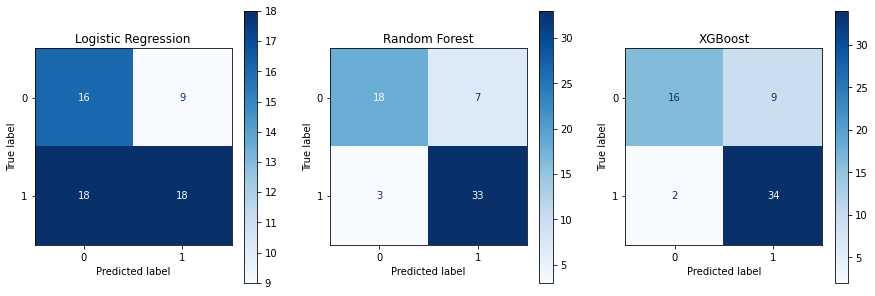

In [17]:
# Print classification reports for each model
print('Logistic Regression:')
print(classification_report(y_test, lr_pred))

print('Random Forest:')
print(classification_report(y_test, rf_pred))

print('XGBoost:')
print(classification_report(y_test, xgb_pred))

# Plot confusion matrices for each model
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].set_title('Logistic Regression')
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, ax=axs[0], cmap=plt.cm.Blues, normalize=None)

axs[1].set_title('Random Forest')
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=axs[1], cmap=plt.cm.Blues, normalize=None)

axs[2].set_title('XGBoost')
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=axs[2], cmap=plt.cm.Blues, normalize=None)

plt.show()

### Classification Model for new dataset

In [16]:
# data preparation
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_new_train.drop(['label'], axis=1), df_new_train['label'], test_size=0.2, random_state=42)
X_train.shape

(233, 27)

In [17]:
# model training
# Train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

/opt/anaconda3/envs/ytbenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.45      0.51        22
           1       0.71      0.81      0.76        37

    accuracy                           0.68        59
   macro avg       0.65      0.63      0.64        59
weighted avg       0.67      0.68      0.67        59

Random Forest:
              precision    recall  f1-score   support

           0       0.47      0.32      0.38        22
           1       0.66      0.78      0.72        37

    accuracy                           0.61        59
   macro avg       0.56      0.55      0.55        59
weighted avg       0.59      0.61      0.59        59

XGBoost:
              precision    recall  f1-score   support

           0       0.35      0.27      0.31        22
           1       0.62      0.70      0.66        37

    accuracy                           0.54        59
   macro avg       0.49      0.49      0.48        59
weighted avg       0.52      

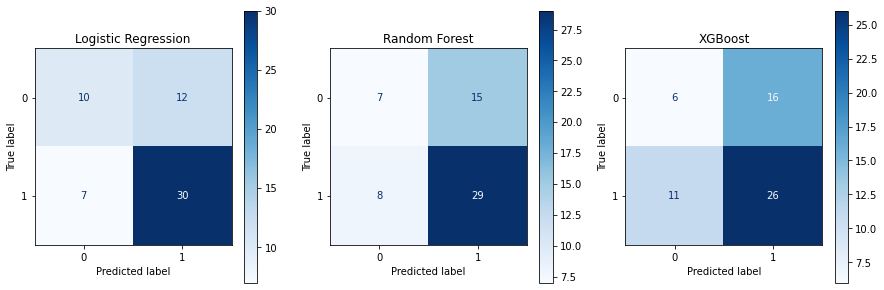

In [18]:
# Print classification reports for each model
print('Logistic Regression:')
print(classification_report(y_test, lr_pred))

print('Random Forest:')
print(classification_report(y_test, rf_pred))

print('XGBoost:')
print(classification_report(y_test, xgb_pred))

# Plot confusion matrices for each model
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].set_title('Logistic Regression')
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, ax=axs[0], cmap=plt.cm.Blues, normalize=None)

axs[1].set_title('Random Forest')
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=axs[1], cmap=plt.cm.Blues, normalize=None)

axs[2].set_title('XGBoost')
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=axs[2], cmap=plt.cm.Blues, normalize=None)

plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Load data and split into training and validation sets
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_classes=2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a random forest classifier object
rfc = RandomForestClassifier()

# Perform a grid search with cross-validation
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)
